In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Notes:

- missing routes, see notes below, need to fix potentially
- only considering weekday (not weekday standard)


In [2]:
# Import statements:

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
# Local data paths:

GTFS_DATA_PATH = "mmt_gtfs/"
import os; os.listdir(GTFS_DATA_PATH) # Peak whats in the directory 

['fare_attributes.txt',
 'transfers.txt',
 'agency.txt',
 'fare_rules.txt',
 'calendar_dates.txt',
 'stop_times.txt',
 'shapes.txt',
 'trips.txt',
 'feed_info.txt',
 'stops.txt',
 'linked_datasets.txt',
 'stop_features.txt',
 'calendar.txt',
 'routes.txt',
 'translations.txt']

In [4]:
def getPandasDFCSV(path, file, sep=','):  
    """ Keyword Arg sep: deliminator used in txt file (default = ',')"""
    pandasDF = pd.read_csv(path +  file, sep=sep)
    return pandasDF

In [5]:
stop_times_df = getPandasDFCSV(GTFS_DATA_PATH, 'stop_times.txt')
stop_times_df.info()
stop_times_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217197 entries, 0 to 217196
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              217197 non-null  int64  
 1   stop_sequence        217197 non-null  int64  
 2   stop_id              217197 non-null  int64  
 3   pickup_type          217197 non-null  int64  
 4   drop_off_type        217197 non-null  int64  
 5   arrival_time         217197 non-null  object 
 6   departure_time       217197 non-null  object 
 7   timepoint            217197 non-null  int64  
 8   stop_headsign        217197 non-null  object 
 9   shape_dist_traveled  217197 non-null  float64
dtypes: float64(1), int64(6), object(3)
memory usage: 16.6+ MB


,trip_id,stop_sequence,stop_id,pickup_type,drop_off_type,arrival_time,departure_time,timepoint,stop_headsign,shape_dist_traveled
0,9999999,1,7605,0,1,5:27:00,5:27:00,1,EAST TRANSFER,0.0249
1,9999999,2,7739,0,0,5:27:40,5:27:40,0,EAST TRANSFER,0.2003
2,9999999,3,7119,0,0,5:28:33,5:28:33,0,EAST TRANSFER,0.4352


In [6]:
trips_df = getPandasDFCSV(GTFS_DATA_PATH, 'trips.txt')
trips_df.info()
trips_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5857 entries, 0 to 5856
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   route_id               5857 non-null   int64 
 1   route_short_name       5857 non-null   int64 
 2   service_id             5857 non-null   object
 3   trip_id                5857 non-null   int64 
 4   trip_headsign          5857 non-null   object
 5   direction_id           5857 non-null   int64 
 6   direction_name         5857 non-null   object
 7   block_id               5857 non-null   int64 
 8   shape_id               5857 non-null   int64 
 9   shape_code             5857 non-null   object
 10  trip_type              5272 non-null   object
 11  trip_sort              5857 non-null   int64 
 12  wheelchair_accessible  5857 non-null   int64 
 13  bikes_allowed          5857 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 640.7+ KB


,route_id,route_short_name,service_id,trip_id,trip_headsign,direction_id,direction_name,block_id,shape_id,shape_code,trip_type,trip_sort,wheelchair_accessible,bikes_allowed
0,9041,16,92_WKD,9999999,EAST TRANSFER,0,East Transfer,193133,55293,P16E,D,19620,1,1
1,9028,2,92_WKD,1007843,NORTH TRANSFER: VIA SHERMAN,0,North Transfer,194263,55156,2S,W,20100,1,1
2,9028,2,92_WKD,1007844,NORTH TRANSFER: VIA FORDEM,0,North Transfer,194056,55154,2F,W,21600,1,1


In [7]:
stops_df = getPandasDFCSV(GTFS_DATA_PATH, 'stops.txt')
stops_df.info()
stops_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              2130 non-null   int64  
 1   stop_code            2130 non-null   object 
 2   stop_name            2130 non-null   object 
 3   stop_desc            2130 non-null   object 
 4   stop_lat             2130 non-null   float64
 5   stop_lon             2130 non-null   float64
 6   agency_id            2130 non-null   object 
 7   jurisdiction_id      2130 non-null   object 
 8   location_type        2130 non-null   int64  
 9   parent_station       5 non-null      float64
 10  relative_position    2130 non-null   int64  
 11  cardinal_direction   2122 non-null   float64
 12  wheelchair_boarding  2130 non-null   int64  
 13  primary_street       2130 non-null   object 
 14  address_range        2130 non-null   int64  
 15  cross_location       2130 non-null   o

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,agency_id,jurisdiction_id,location_type,parent_station,relative_position,cardinal_direction,wheelchair_boarding,primary_street,address_range,cross_location
0,1110,1110,E Dayton & Wisconsin (WB),This EVENT/DETOUR ONLY stop (#1110) is westbou...,43.076428,-89.385920,MMT,CMAD,0,NaN,3,270.0,1,E Dayton,2,Wisconsin
1,1111,1111,W Doty & M L K Junior (EB),This EVENT/DETOUR ONLY stop (#1111) is eastbou...,43.072938,-89.382354,MMT,CMAD,0,NaN,3,90.0,1,W Doty,1,M L K Junior
2,1124,1124,S Fairchild & W Main (SB),This EVENT/DETOUR ONLY stop (#1124) is southbo...,43.072467,-89.385273,MMT,CMAD,0,NaN,3,180.0,1,S Fairchild,98,W Main


Want to go through trips data to pull out a characteristic trip for each route, should be a trip with the maximum number of stops, could look at trips with the min later for comparison, or look at time variance later as well. 

In [8]:
trips_df = getPandasDFCSV(GTFS_DATA_PATH, 'trips.txt')
trips_df.info()
trips_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5857 entries, 0 to 5856
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   route_id               5857 non-null   int64 
 1   route_short_name       5857 non-null   int64 
 2   service_id             5857 non-null   object
 3   trip_id                5857 non-null   int64 
 4   trip_headsign          5857 non-null   object
 5   direction_id           5857 non-null   int64 
 6   direction_name         5857 non-null   object
 7   block_id               5857 non-null   int64 
 8   shape_id               5857 non-null   int64 
 9   shape_code             5857 non-null   object
 10  trip_type              5272 non-null   object
 11  trip_sort              5857 non-null   int64 
 12  wheelchair_accessible  5857 non-null   int64 
 13  bikes_allowed          5857 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 640.7+ KB


,route_id,route_short_name,service_id,trip_id,trip_headsign,direction_id,direction_name,block_id,shape_id,shape_code,trip_type,trip_sort,wheelchair_accessible,bikes_allowed
0,9041,16,92_WKD,9999999,EAST TRANSFER,0,East Transfer,193133,55293,P16E,D,19620,1,1
1,9028,2,92_WKD,1007843,NORTH TRANSFER: VIA SHERMAN,0,North Transfer,194263,55156,2S,W,20100,1,1
2,9028,2,92_WKD,1007844,NORTH TRANSFER: VIA FORDEM,0,North Transfer,194056,55154,2F,W,21600,1,1


In [9]:
# list of possible trips:

service_id_list = []

for i in trips_df['service_id']:
    if i not in service_id_list:
        service_id_list.append(i)
print(service_id_list)

['92_WKD', '92_SAT', '92_SUN', '92_HOL', '92_MWK', '92_WKD:R', '92_SAT:R', '92_SUN:R', '92_HOL:R', '92_SAT:L', '92_SUN:L', '92_WKD:L#6', '92_WKD:L=6', '92_WKD:S', '92_SAT:S', '92_SUN:S', '92_WKD:S#6', '92_WKD:S=6']


In [10]:
# list of possible routes:

route_short_name_list = []

for i in trips_df['route_short_name']:
    if i not in route_short_name_list:
        route_short_name_list.append(i)

route_short_name_list.sort()
print(route_short_name_list)

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 59, 63, 67, 68, 70, 72, 73, 75, 78, 80, 81, 82, 84]


59, 63, 68, : weekend, holiday only

78: weekend only

80, 84 weekday standard

In [11]:
trips_df_weekday_peak = trips_df[trips_df['service_id'] == '92_WKD']
trips_df_weekday_peak

,route_id,route_short_name,service_id,trip_id,trip_headsign,direction_id,direction_name,block_id,shape_id,shape_code,trip_type,trip_sort,wheelchair_accessible,bikes_allowed
0,9041,16,92_WKD,9999999,EAST TRANSFER,0,East Transfer,193133,55293,P16E,D,19620,1,1
1,9028,2,92_WKD,1007843,NORTH TRANSFER: VIA SHERMAN,0,North Transfer,194263,55156,2S,W,20100,1,1
2,9028,2,92_WKD,1007844,NORTH TRANSFER: VIA FORDEM,0,North Transfer,194056,55154,2F,W,21600,1,1
3,9028,2,92_WKD,1007499,NORTH TRANSFER: VIA SHERMAN,0,North Transfer,194052,55156,2S,D,23400,1,1
4,9028,2,92_WKD,1007497,NORTH TRANSFER: VIA FORDEM,0,North Transfer,194058,55154,2F,D,25200,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,9084,75,92_WKD,1012813,CAPITOL SQUARE: VIA VERONA,1,Capitol Square,194507,55456,75ip,W,61200,1,1
1431,9084,75,92_WKD,1011954,CAPITOL SQUARE: VIA VERONA,1,Capitol Square,194393,55456,75ip,W,61500,1,1
1432,9084,75,92_WKD,1011953,CAPITOL SQUARE: VIA VERONA,1,Capitol Square,194394,55455,75ia,W,63300,1,1
1433,9084,75,92_WKD,1011952,CAPITOL SQUARE: VIA VERONA,1,Capitol Square,194395,55455,75ia,W,66000,1,1


In [12]:
# make a dictionary of routes with trip ID's for weekday service:

tripIDList_forRoutes_weekday92 = dict()

for i in route_short_name_list:
    trip_list = []
    for j in trips_df_weekday_peak[trips_df_weekday_peak['route_short_name'] == i].iterrows():
        trip_list.append(j[1]['trip_id'])
    tripIDList_forRoutes_weekday92[i] = trip_list

#tripIDList_forRoutes_weekday92

In [13]:
for route in tripIDList_forRoutes_weekday92:
    
    for trip in tripIDList_forRoutes_weekday92[route]:
        trip_stop_time_df = stop_times_df[stop_times_df['trip_id'] == trip]

In [14]:
def get_stop_distances(trip):
    """ getting the stop spacing for a given trip. Stop spacing is defined as the distance travelled by bus between two cosecutive stops. 
    Should mirror natural walking terrain better than distance between two globe points.
    
    return: numpy array - contains # of stops - 1 elements that are the distances between stops driven by the bus
    """
    stop_dist_array = []
    trip_stop_time_df = stop_times_df[stop_times_df['trip_id'] == trip]
    distance_travelled = np.array(trip_stop_time_df['shape_dist_traveled'])
    for i in range(len(distance_travelled)-1):
        stop_spacing = distance_travelled[i+1] - distance_travelled[i]
        stop_dist_array.append(stop_spacing)
        
    return stop_dist_array

print(get_stop_distances(9999999))

[0.1754, 0.23489999999999997, 0.09029999999999999, 0.25650000000000006, 0.24869999999999992, 0.09620000000000006, 0.20589999999999997, 0.21829999999999994, 0.1684000000000001, 0.25239999999999996, 0.3065, 0.1383000000000001, 0.11730000000000018, 0.20689999999999964, 0.15210000000000035, 0.1325999999999996, 0.15980000000000016, 0.20020000000000016, 0.3004000000000002]


In [15]:
all_trip_distances_forRoutes_weekday92 = dict()


for route in tripIDList_forRoutes_weekday92:
    #print(route)
    all_trip_distances = []
    for trip in tripIDList_forRoutes_weekday92[route]:
        #print(trip)
        trip_distances = get_stop_distances(trip)
        all_trip_distances.append(trip_distances)
    all_trip_distances_forRoutes_weekday92[route] = all_trip_distances
    
#all_trip_distances_forRoutes_weekday92

In [155]:
avg_dist_forRoutes_weekday92 = dict()

for route in all_trip_distances_forRoutes_weekday92:
    route_averages = []
    
    top_average = []
    top_quartile_avg = []
    mid_top_avg = []
    averages = []
    mid_bottom_avg = []
    bottom_qartile_avg = []
    bottom_average = []
    
    for trip in all_trip_distances_forRoutes_weekday92[route]:
        
        if route == 23:
            print(trip)
        
        trip.sort()
        top = int(len(trip)/4)*3
        bottom = int(len(trip)/4)
        
        top_average.append(np.max(trip))
        top_quartile_avg.append(np.average(trip[top:]))
        mid_top_avg.append(np.min(trip[top:]))
        averages.append(np.average(trip))
        mid_bottom_avg.append(np.max(trip[:bottom]))
        bottom_qartile_avg.append(np.average(trip[:bottom]))
        bottom_average.append(np.min(trip))
        
    if len(stats.mode(averages)[0]) == 0:
        continue
       
    if route == 17:
        print(route_averages)
        
    route_averages.append(np.float(stats.mode(top_average)[0]))
    route_averages.append(np.float(stats.mode(top_quartile_avg)[0]))
    route_averages.append(np.float(stats.mode(mid_top_avg)[0]))
    route_averages.append(np.float(stats.mode(averages)[0])) 
    route_averages.append(np.float(stats.mode(mid_bottom_avg)[0]))
    route_averages.append(np.float(stats.mode(bottom_qartile_avg)[0]))
    route_averages.append(np.float(stats.mode(bottom_average)[0]))
    
    if route == 23:
        print(route_averages)
        
    avg_dist_forRoutes_weekday92[route] = route_averages
    
#avg_dist_forRoutes_weekday92

[]
[0.1345, 0.1486, 0.15389999999999998, 0.155, 0.19620000000000104, 0.24399999999999977, 0.3422999999999998, 0.36660000000000004, 0.43180000000000085, 0.4456, 0.7639000000000005, 0.7950999999999997, 1.8939, 1.9222, 2.489399999999999]
[0.1345, 0.1486, 0.15389999999999998, 0.155, 0.19620000000000104, 0.24399999999999977, 0.3422999999999998, 0.36660000000000004, 0.43180000000000085, 0.4456, 0.7639000000000005, 0.7950999999999997, 1.8939, 1.9222, 2.489399999999999]
[0.1345, 0.1486, 0.15389999999999998, 0.155, 0.19620000000000104, 0.24399999999999977, 0.3422999999999998, 0.36660000000000004, 0.43180000000000085, 0.4456, 0.7639000000000005, 0.7950999999999997, 1.8939, 1.9222, 2.489399999999999]
[0.1345, 0.1486, 0.15389999999999998, 0.155, 0.18420000000000059, 0.24650000000000105, 0.3064999999999998, 0.3110999999999997, 0.33590000000000053, 0.3371999999999993, 0.3573000000000004, 0.36710000000000065, 0.3868999999999989, 0.4456, 0.4545999999999992, 0.4698000000000011, 0.7639000000000005, 1.89

In [144]:
routes = list(avg_dist_forRoutes_weekday92.keys())
print(routes)

route_avgs = list(avg_dist_forRoutes_weekday92.values())

top_averages = [route_avgs[i][0] for i in range(len(route_avgs))]
top_quartile_averages = [route_avgs[i][1] for i in range(len(route_avgs))]
mid_top_averages = [route_avgs[i][2] for i in range(len(route_avgs))]
average_averages = [route_avgs[i][3] for i in range(len(route_avgs))]
mid_bottom_averages = [route_avgs[i][4] for i in range(len(route_avgs))]
bottom_quartile_averages = [route_avgs[i][5] for i in range(len(route_avgs))]
bottom_averages = [route_avgs[i][6] for i in range(len(route_avgs))]

print(top_averages[17])
print(top_quartile_averages[17])
print(mid_top_averages[17])
print(average_averages[17])
print(mid_bottom_averages[17])
print(bottom_quartile_averages[17])
print(bottom_averages[17])

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 67, 70, 72, 73, 75]
3.5966999999999993
1.7292999999999998
0.4698000000000011
0.64857
0.18420000000000059
0.1552400000000001
0.1345


In [83]:
def bar_plot_routes(routes, counts, xlabel, ylabel, title):
    x = [i for i in range(len(routes))]
    plt.figure(figsize=(16, 8))
    plt.bar(x, counts, tick_label = routes)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

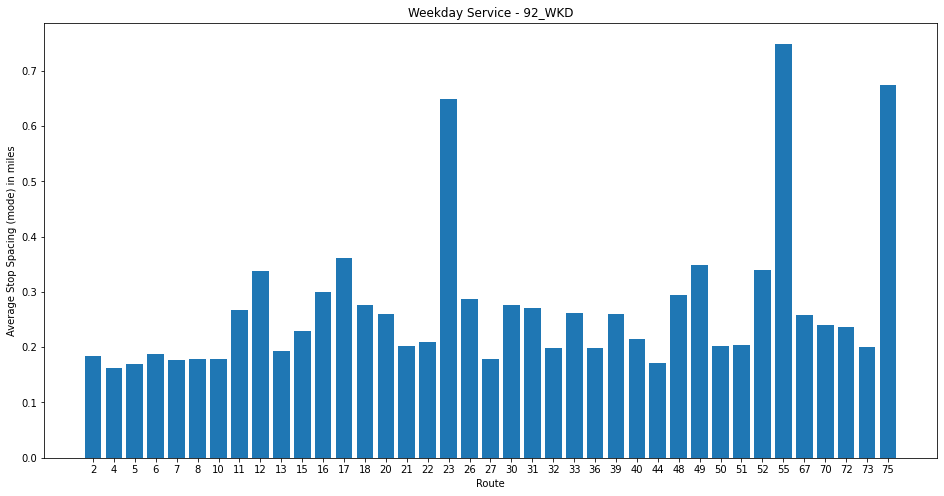

In [84]:
bar_plot_routes(routes, average_averages, "Route", "Average Stop Spacing (mode) in miles", "Weekday Service - 92_WKD")

In [85]:
routes_ticks_loc = [i for i in range(len(routes))]
routes_ticks_labels = [str(i) for i in routes]

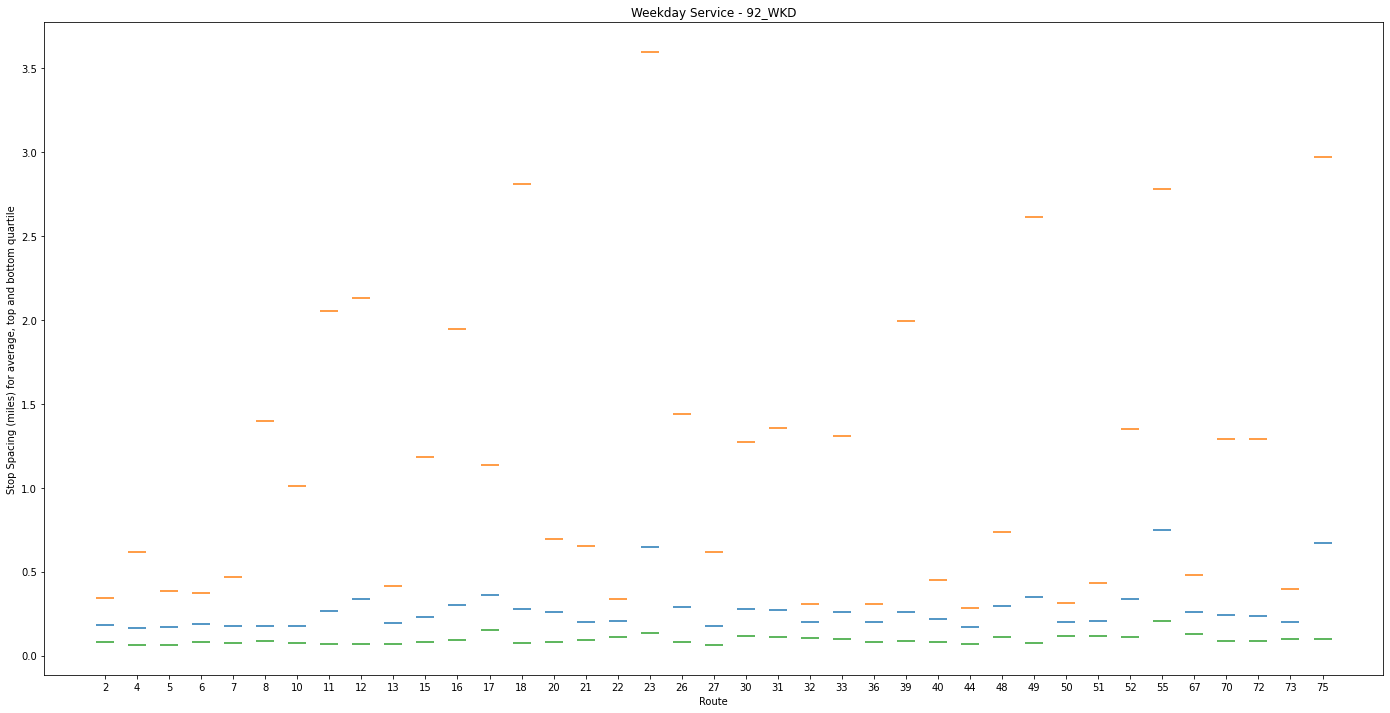

In [86]:
plt.figure(figsize=(24, 12))

plt.scatter(routes_ticks_loc, average_averages, marker="_", s=300)
plt.scatter(routes_ticks_loc, top_averages, marker="_", s=300)
plt.scatter(routes_ticks_loc, bottom_averages, marker="_", s=300)

plt.xticks(routes_ticks_loc, routes_ticks_labels)
plt.xlabel("Route")
plt.ylabel("Stop Spacing (miles) for average, top and bottom quartile")
plt.title("Weekday Service - 92_WKD")
plt.show()

Text(0.5, 0.98, 'Categorical Plotting')

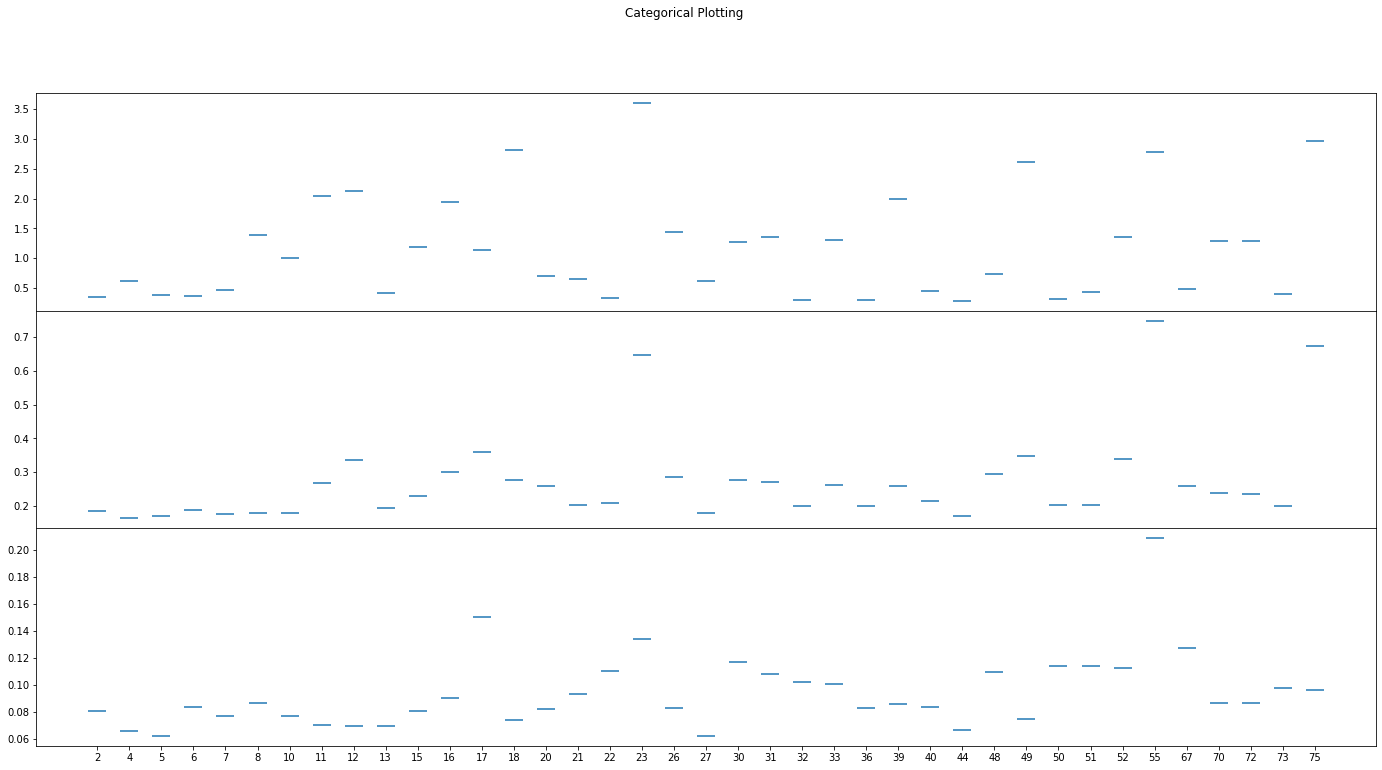

In [159]:
fig, axs = plt.subplots(3, 1, figsize=(24, 12), sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].scatter(routes_ticks_loc, top_averages, marker="_", s=300)
axs[1].scatter(routes_ticks_loc, average_averages, marker="_", s=300)
axs[2].scatter(routes_ticks_loc, bottom_averages, marker="_", s=300)

plt.xticks(routes_ticks_loc, routes_ticks_labels)
fig.suptitle('Categorical Plotting')

In [145]:
print(top_averages[17])
print(top_quartile_averages[17])
print(mid_top_averages[17])
print(average_averages[17])
print(mid_bottom_averages[17])
print(bottom_quartile_averages[17])
print(bottom_averages[17])

3.5966999999999993
1.7292999999999998
0.4698000000000011
0.64857
0.18420000000000059
0.1552400000000001
0.1345


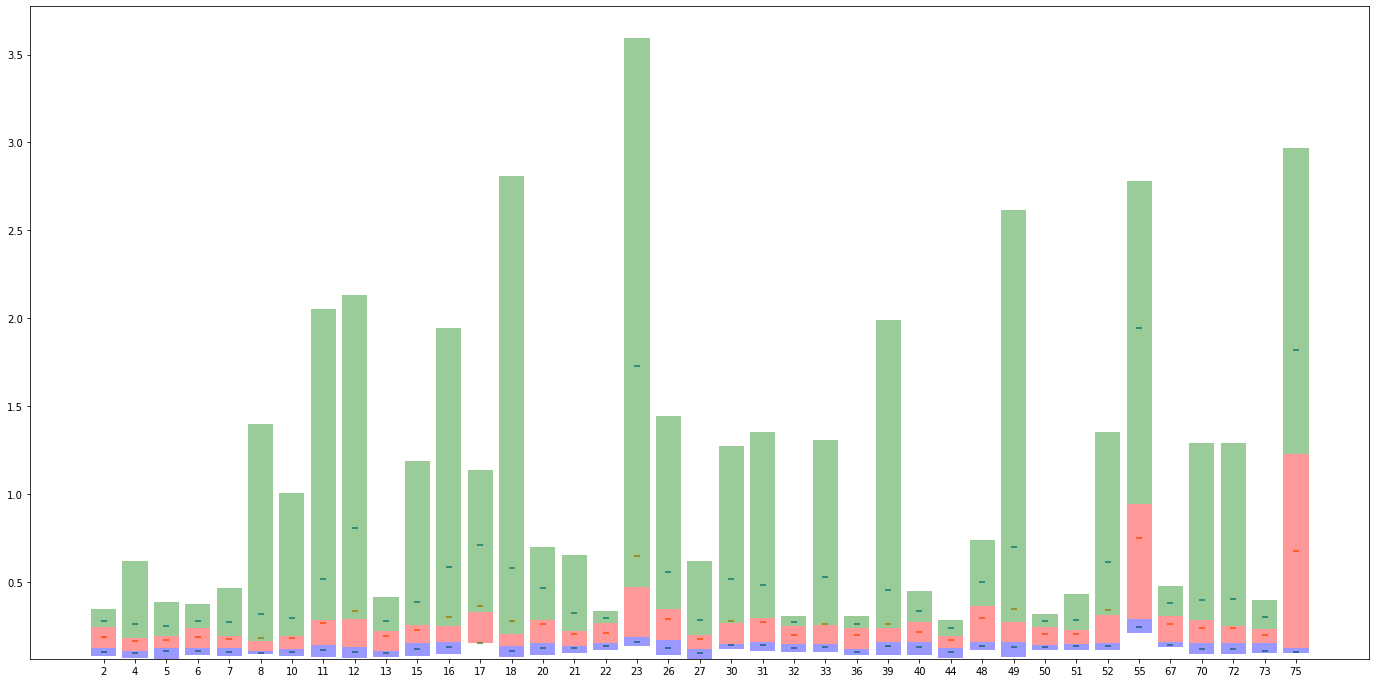

In [167]:
top_quartile_height = [top_averages[i]-mid_top_averages[i]  for i in range(len(top_averages))]
top_quartile_bottom = [(mid_top_averages[i]) for i in range(len(top_averages))]

mid_quartile_height = [mid_top_averages[i]-mid_bottom_averages[i]  for i in range(len(top_averages))]
mid_quartile_bottom = [(mid_bottom_averages[i]) for i in range(len(top_averages))]

bottom_quartile_height = [mid_bottom_averages[i]-bottom_averages[i]  for i in range(len(top_averages))]
bottom_quartile_bottom = [(bottom_averages[i]) for i in range(len(top_averages))]

plt.figure(figsize=(24, 12))

plt.bar(routes_ticks_loc, height=top_quartile_height, bottom=top_quartile_bottom, alpha=.4, width=.8, color='g')
plt.bar(routes_ticks_loc, height=mid_quartile_height, bottom=mid_quartile_bottom, alpha=.4, width=.8, color="r")
plt.bar(routes_ticks_loc, height=bottom_quartile_height, bottom=bottom_quartile_bottom, alpha=.4, width=.8, color="b")

plt.scatter(routes_ticks_loc, top_quartile_averages, marker="_")
plt.scatter(routes_ticks_loc, average_averages, marker="_")
plt.scatter(routes_ticks_loc, bottom_quartile_averages, marker="_")


plt.xticks(routes_ticks_loc, routes_ticks_labels)
plt.show()